In [11]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_folder = Path("data").resolve()


In [12]:
# Read in the data
df = pd.read_csv(data_folder / "marketing_data.csv", sep=";")

In [13]:
# Change to dateformat
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")

In [14]:
# Check for missing values
df.isna().sum()

site           0
country        0
date           0
total_spend    0
impressions    0
sessions       0
conversions    0
dtype: int64

In [15]:
# Group data by cohorts 

df['cohort'] = df['site'] + '_' + df['country']

df = df.groupby(['cohort', 'date']).sum().reset_index()

In [16]:
df.cohort.unique()

array(['CAP_UK', 'CAP_US', 'GA_UK', 'GA_US'], dtype=object)

In [17]:
# Calculate key KPIS

df['conversion_per_session'] = df['conversions'] / df['sessions']
df['price_per_impression'] = df['total_spend'] / df['impressions']

In [18]:
# print min and max date for each cohort
df.groupby('cohort').agg({'date': ['min', 'max']})

date           
              min        max
cohort                      
CAP_UK 2022-01-01 2023-01-31
CAP_US 2022-01-01 2023-01-31
GA_UK  2022-01-01 2023-01-31
GA_US  2022-01-01 2023-01-31

In [19]:
# Make sure we have daily data
import warnings
warnings.filterwarnings("ignore")
df_daily = df.groupby(['cohort', pd.Grouper(key='date', freq='D')])['total_spend', 'impressions', 'sessions', 'conversions', 'price_per_impression', 'conversion_per_session'].sum()

In [20]:
# Observe some quick statistics for each cohort

pd.set_option('display.max_columns', None)
# Show statistics
df_daily.groupby('cohort').describe().T.style.background_gradient(cmap='coolwarm')


Observations:

- A quick examination of the computed statistics for each cohort suggests the potential presence of outliers.

- This seems particularly evident in the CAP_US and CAP_UK cohorts regarding total spending and impressions.

Next steps:

- We need to conduct further analysis to confirm whether outliers are present.

- It would be helpful to visualize the relationships between variables, particularly for key KPIs such as price_per_impression and conversion_per_session, to assess linearity.

- Additionally, since we're working with time series data, it's important to identify any seasonality or trends within the data.

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_seasonal_decomposition(df:pd.DataFrame, feature: str, period: int =30, seasonality: str='Monthly'):

    """ Plot seasonal decomposition for a given feature


    Args:
        df (pd.DataFrame): desired dataframe to plot
        feature (str): feature to plot
        period (int, optional): Desired period across time. Defaults to 30.
        seasonality (str, optional): Defaults to 'Monthly'.
    """


    for cohort in df.index.levels[0]:
        df_cohort = df.loc[cohort]
        series = df_cohort[feature]
        result = sm.tsa.seasonal_decompose(series, model='additive', period=period)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
        result.observed.plot(ax=ax[0], label='Observed')
        result.trend.plot(ax=ax[0], label='Trend')
        result.seasonal.plot(ax=ax[0], label='Seasonal')
        ax[0].set_title(f'{seasonality} {feature} {cohort}')
        ax[0].legend()

        # Nicer way to see residuals around zero
        ax[1].scatter(df_cohort.index, result.resid)
        ax[1].axhline(y=0, color='red', linestyle='--')
        ax[1].set_title('Residuals')
        ax[1].set_ylabel('Residuals')
        ax[1].set_xlabel('Date')
        
        fig.tight_layout()
        plt.show()



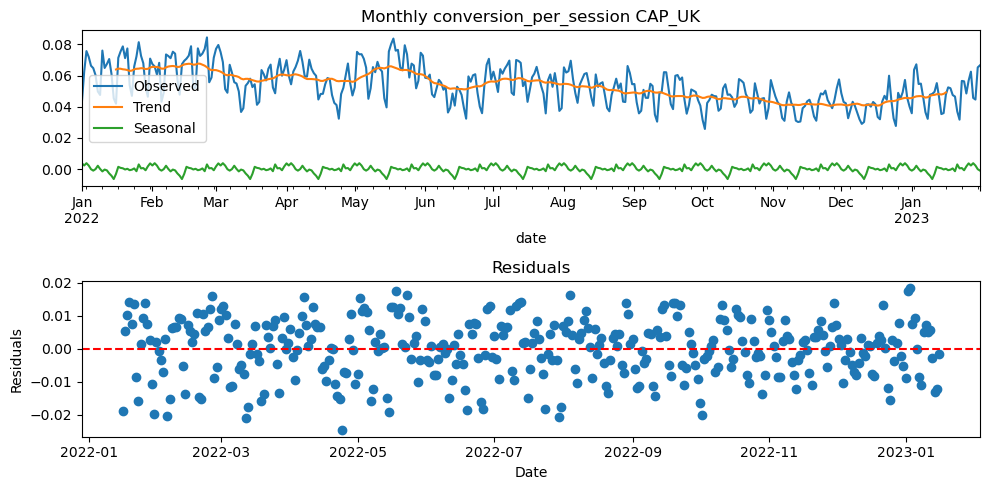

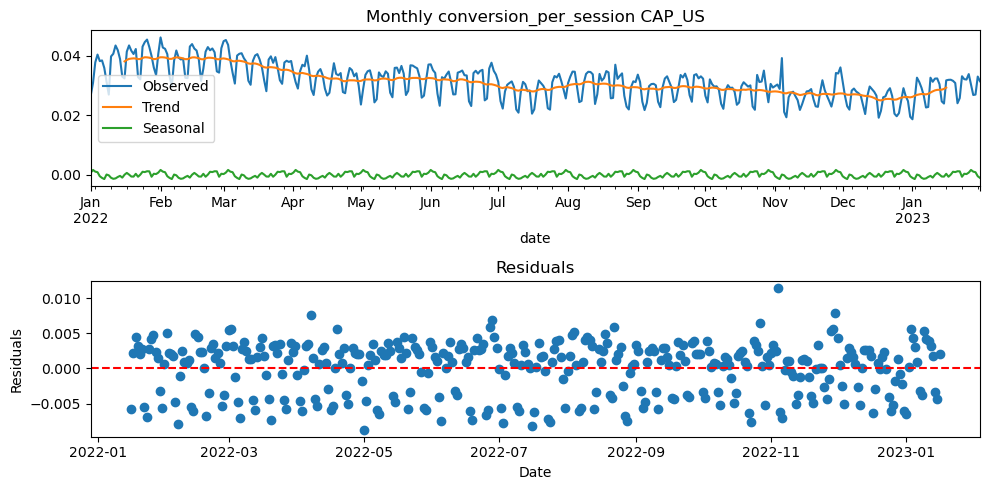

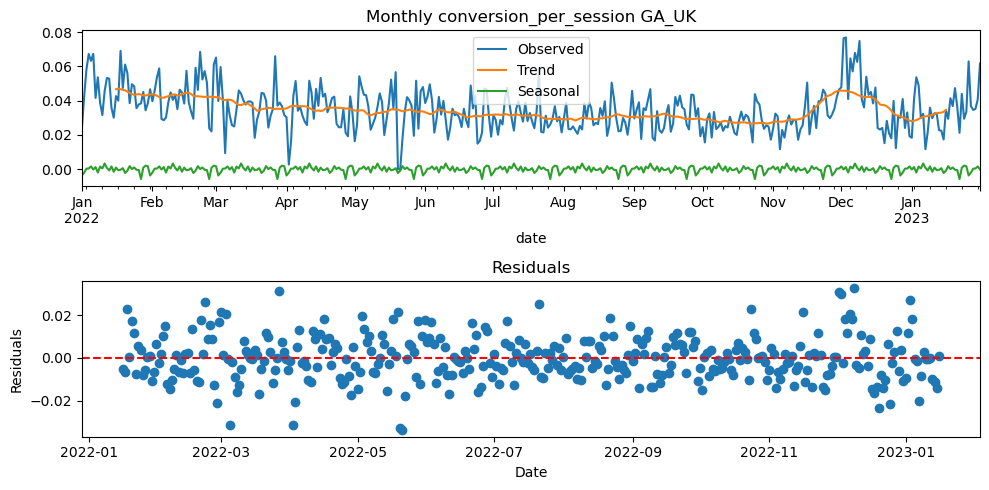

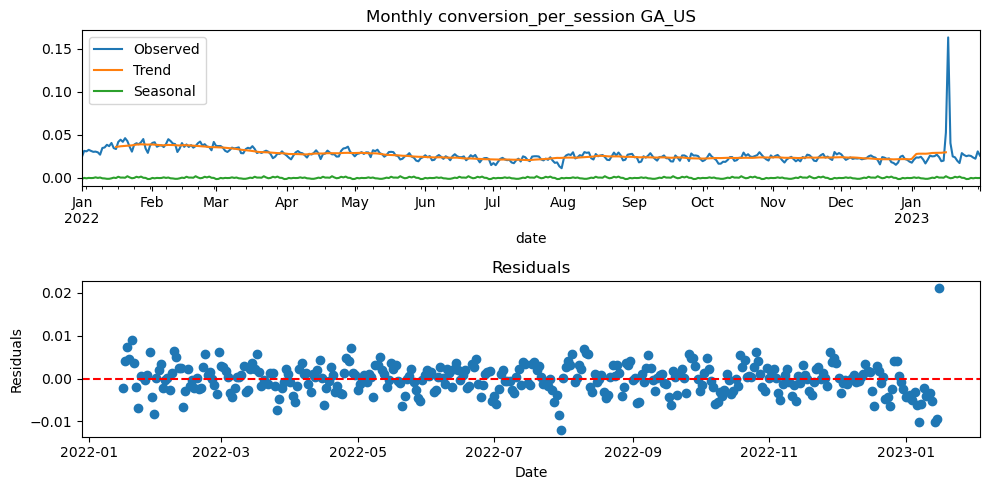

In [22]:
plot_seasonal_decomposition(df_daily, 'conversion_per_session', period=30, seasonality='Monthly')


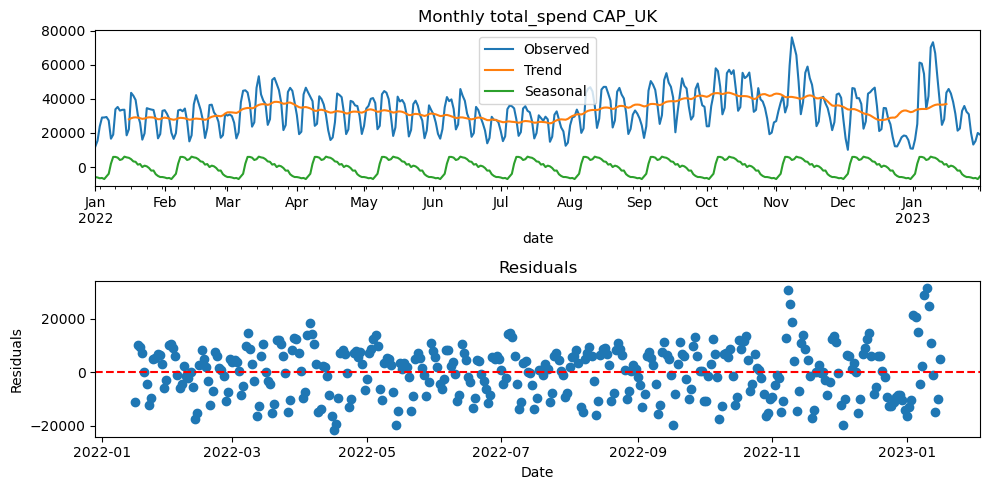

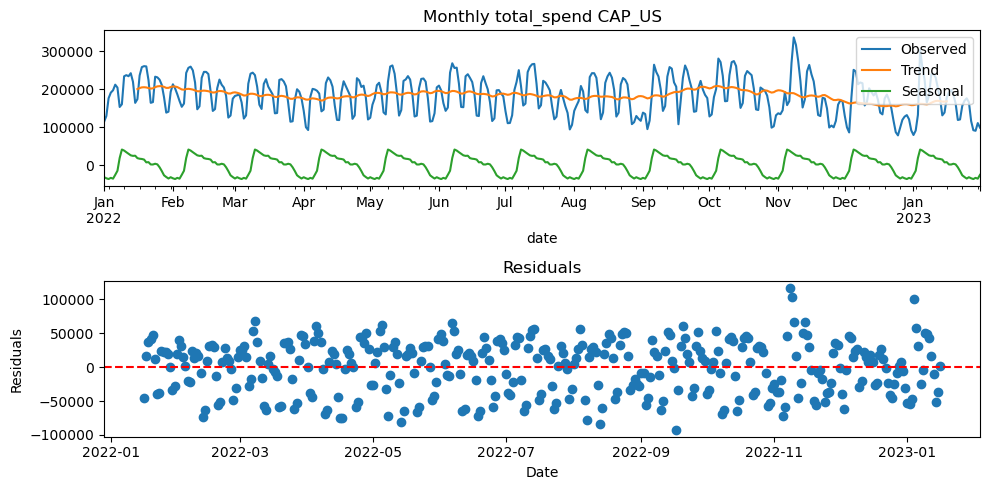

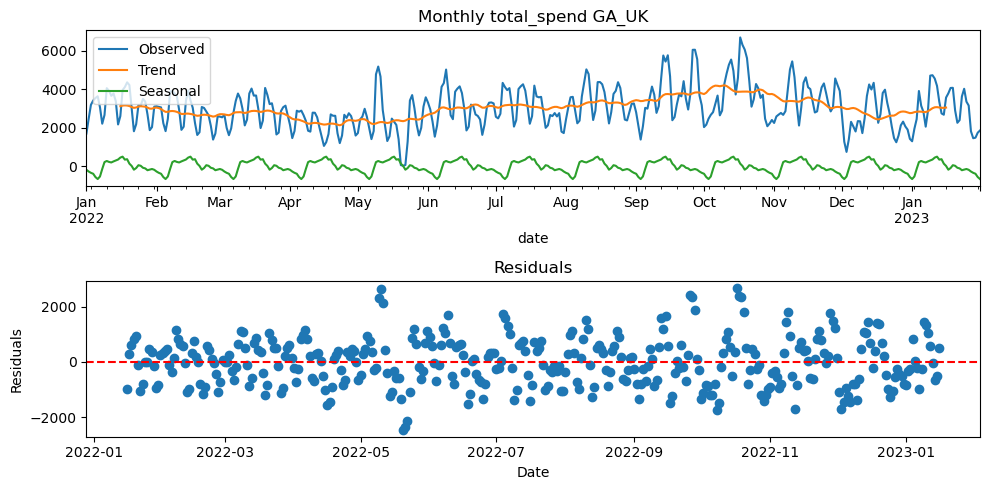

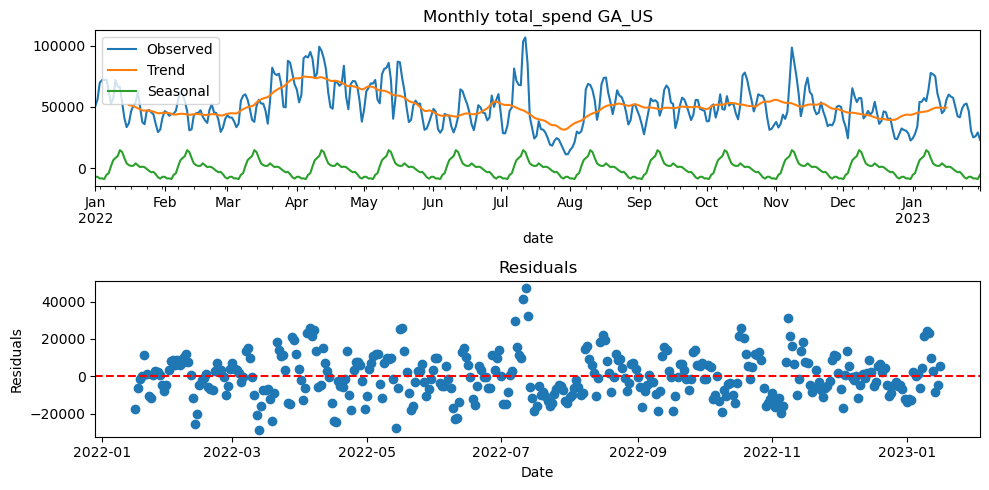

In [23]:
plot_seasonal_decomposition(df_daily, 'total_spend', period=30, seasonality='Monthly')

Brief Dictionary of Terms:

Observed: the original time series data.

Trend: the estimated trend component of the time series, which represents the long-term movement of the time series.

Seasonal: the estimated seasonal component of the time series, which represents the cyclical patterns of the time series.

Residual: the estimated residual component of the time series, which represents the random fluctuations around the trend and seasonal components


Question: Does the data show evidence of monthly seasonality?

Observations:

- For the CAP_UK cohort, the seasonal component exhibits a repeating pattern at regular intervals. The trend is not significantly flat, and there is a presence of long-term movement across the time series. The residuals display randomness around zero, suggesting that decomposition is likely a good fit for the data.

- For the CAP_US cohort, the seasonal component also presents a repeating pattern at regular intervals. The trend is not significantly flat, and there is a slight presence of long-term movement across the time series. Further analysis is required to determine if there is randomness around zero in the residuals.

- Finally for the cohorts GA_US and GA_UK , the seasonal component, trend, and residual all provide evidence of significant monthly seasonality. Decomposition is likely a good fit for the data.



In [24]:
# set date as index
df = df.set_index('date')
# Create a seperate dataframe for business insights
df_business = df.copy()

In addition to the previously constructed KPIs, providing insights on several other key KPIs of the business would be a valuable contribution to the Marketing team. Based on the data provided, the following KPIs come to mind:


- Cost per Click (CPClick): This metric shows how much it costs for each user click that leads to the site.

- Cost per Conversion (CPC): This metric shows how much it costs to acquire each conversion.

These insights can be further explored with more data and knowledge of the economy and the business. 

This contribution is based on the premise that, besides the groundwork of modeling and the use of data science techniques, tools like dashboards and simple descriptive statistics can be employed to provide valuable insights to the business.

In [25]:
# Potential KPIs that could be useful for business
# Click through rate
#df_business['CTR'] =  df_business['sessions'] / df_business['impressions'] * 100
# Cost per click

df_business['CPClick'] = df_business['total_spend'] / df_business['sessions']

# Cost per conversion
df_business['CPC'] = df_business['total_spend'] / df_business['conversions']


In [16]:
# Useful plots for a dashboard or report for the Marketing team:

# The focus of these plots is to provide descriptive insights into the data, allowing the business team to have a quick overview of the current situation for each campaign.

# A data scientist working with the marketing team would benefit from having more exposure to the business side of things. This would enable them to communicate insights to the business team in an understandable and actionable manner.


import plotly.express as px

df_monthly = df_business.groupby(['cohort', pd.Grouper(freq='M')])['total_spend'].sum()
df_monthly = df_monthly.reset_index()
df_monthly['date'] = df_monthly.date.dt.strftime('%Y-%m')
fig = px.bar(
    df_monthly,
    x='date',
    y='total_spend',
    color='cohort',
    barmode='group',
    title='Total Spend per Month for each Cohort'
)
fig.show()

In [17]:
#df_business.set_index('date', inplace=True)
df_daily_business = df_business.reset_index()

fig = px.line(
    df_daily_business,
    x='date',
    y=['conversion_per_session', 'price_per_impression'],
    color='cohort',

    title='Conversion per session vs Price per impression for  each Cohort'
)
fig.show()

In [18]:

fig = px.bar(
    df_daily_business,
    x='date',
    y='CPClick',
    color='cohort',

    title=' Cost per click  each Cohort'
)
fig.show()


Observations:

- The budget for Capterra US is the largest by a significant difference among all cohorts. Overall, this budget varies between 4.5 and 5.5 million dollars.

- One potential action from this is to calculate the overall ROI for this particular campaign. However, based on the available data, it is not possible since the revenue generated is not provided.

- Upon closely examining the overall budget invested across time and cohorts, there are no significant upticks or downticks in the budget. This is a good sign that the budget is being allocated consistently.

- Overall, the largest budgets go to the US market. Further analysis is needed to detect saturation effects on the market.

- The UK market is significantly smaller than the US market, with around 1 million dollars being allocated across all sites.

- A closer look reveals a significant uptick in the price per impression for the US market with Capterra. The price per impression had a consistent price of around 0.5 dollars. However, on January 17th, it increased to 2.7 dollars. Conversion marginally increased that day. This could be a potential anomaly to investigate.

- This very first day also represented a significant increase in the cost per click, with a value of 6.0 dollars.


In [19]:
# Check for correlations
df.corr().style.background_gradient(cmap='coolwarm')

,total_spend,impressions,sessions,conversions,conversion_per_session,price_per_impression
total_spend,1.000000,0.948602,0.948576,0.921590,-0.167502,0.763479
impressions,0.948602,1.000000,0.999960,0.925777,-0.249476,0.568188
sessions,0.948576,0.999960,1.000000,0.925754,-0.249554,0.568138
conversions,0.921590,0.925777,0.925754,1.000000,0.060440,0.649942
conversion_per_session,-0.167502,-0.249476,-0.249554,0.060440,1.000000,0.144867
price_per_impression,0.763479,0.568188,0.568138,0.649942,0.144867,1.000000


In [26]:
# Visually check presence of linearity between both KPIs

# Check distributions and outliers

# Create a seperate datframe for each cohort
df_cap_us = df[df['cohort'] == 'CAP_US']
df_ga_uk = df[df['cohort'] == 'GA_UK']
df_cap_uk = df[df['cohort'] == 'CAP_UK']
df_ga_us = df[df['cohort'] == 'GA_US']

In [27]:
from typing import List
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_relationships(dataframes: List[pd.DataFrame], cohorts:list,
                       x:str='price_per_impression', 
                       y:str='conversion_per_session'):
    """Plot relationships between two KPIs for each cohort

    Args:
        dataframes (List[pd.DataFrame]): list of dataframes to plot
        cohorts (list): list of cohorts
        x (str, optional): Defaults to 'price_per_impression'.
        y (str, optional):  Defaults to 'conversion_per_session'.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, (cohort, df) in enumerate(zip(cohorts, dataframes)):
        ax = axes[i]
        ax.scatter(df[x], df[y], alpha=0.5)
        corr_coef, _ = pearsonr(df[x], df[y])
        ax.set_title(f'{cohort} (Correlation: {corr_coef:.2f})')
        ax.set_xlabel(x)
        ax.set_ylabel(y)


    plt.tight_layout()
    plt.show()


Original Data:


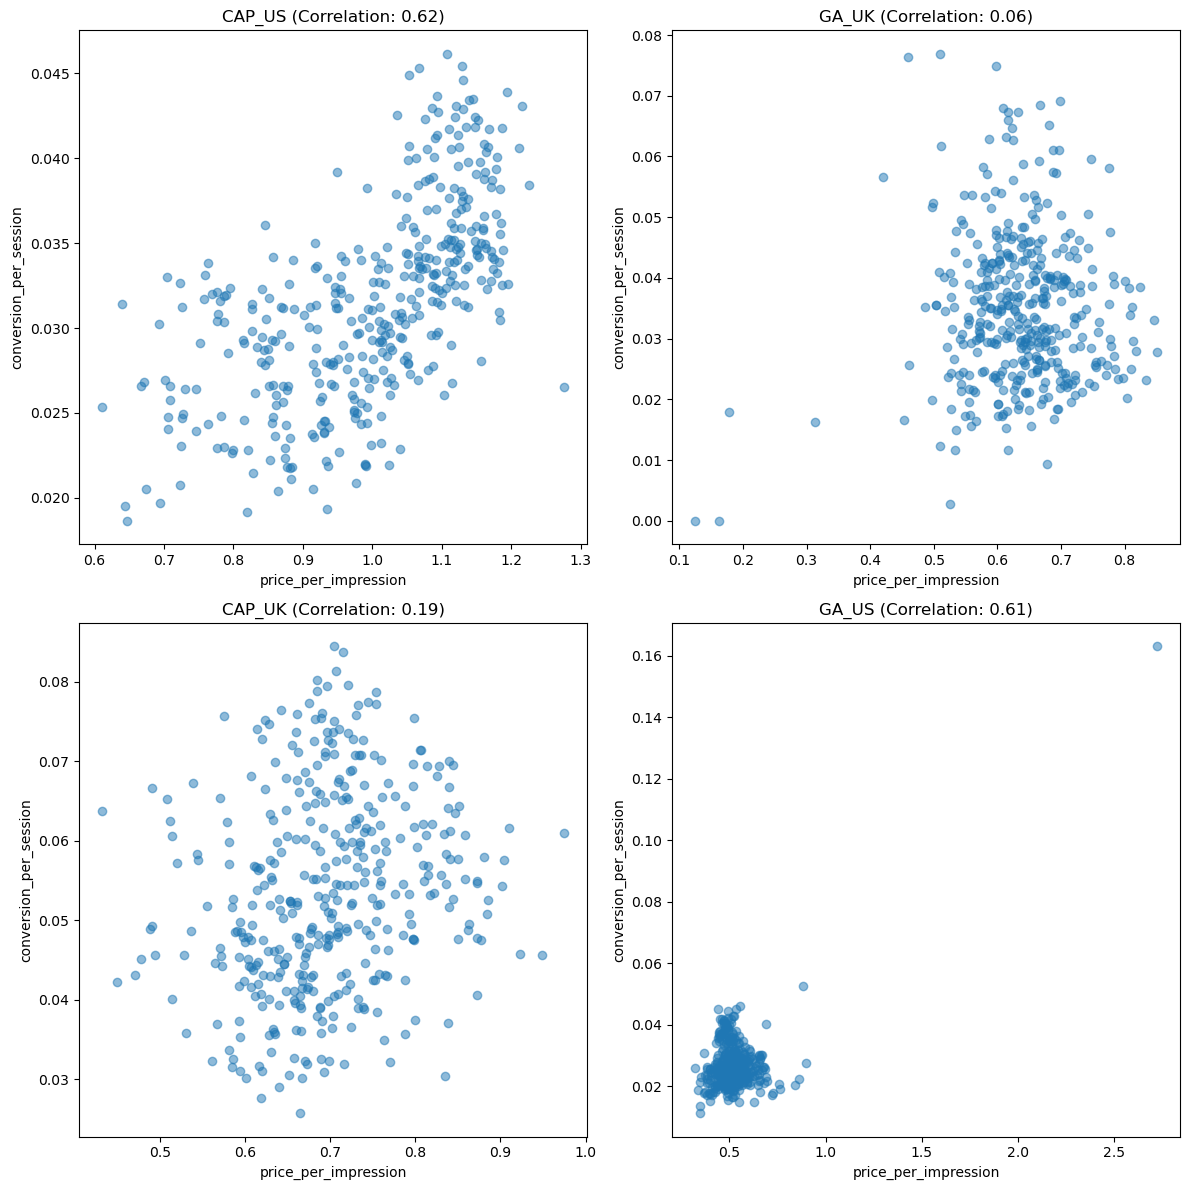

In [28]:
# Original Data
cohorts = ['CAP_US', 'GA_UK', 'CAP_UK', 'GA_US']
dataframes = [df_cap_us, df_ga_uk, df_cap_uk, df_ga_us]
print("Original Data:")
plot_relationships(dataframes, cohorts)

Observations:


- Upon a first observation of the relationshop of the variables there is weak or even null evidence so far of linear relationship 


- Assuming the non-linearity pressence, several methods can be applied:

- Logarithmic transformation.
- Polynomial regression to model the relationship between variables.
- Mean squared error evaluate the model performance

Next steps:

- Keep exploring the data by assesing normal distribution, outliers and check differences between log scale data and original data.

In [15]:
# Log transformed data
df_log = df.copy()
# add a small constant to avoid zero or negative values
min_conversion_per_session = df['conversion_per_session'].min()
min_price_per_impression = df['price_per_impression'].min()
epsilon = max(min_conversion_per_session, min_price_per_impression)

df_log['conversion_per_session'] = np.log(df_log['conversion_per_session'] + epsilon)
df_log['price_per_impression'] = np.log(df_log['price_per_impression'] + epsilon)

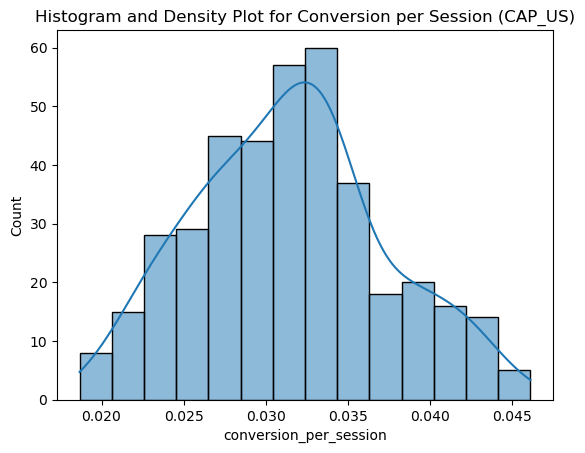

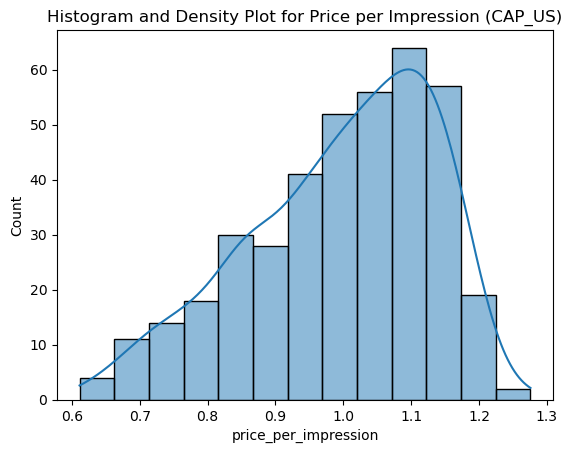

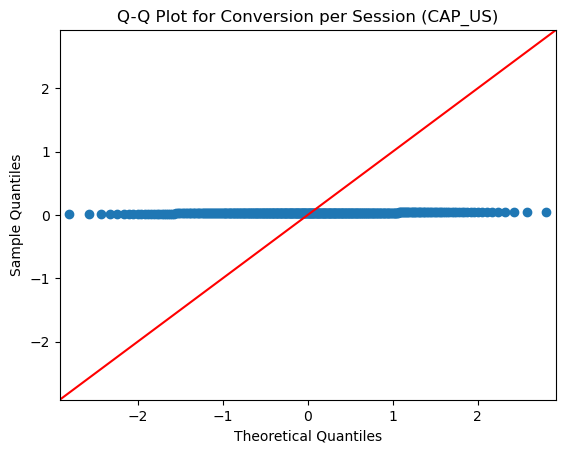

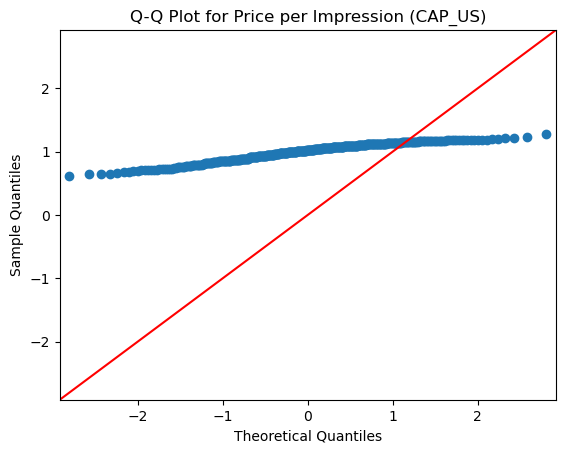

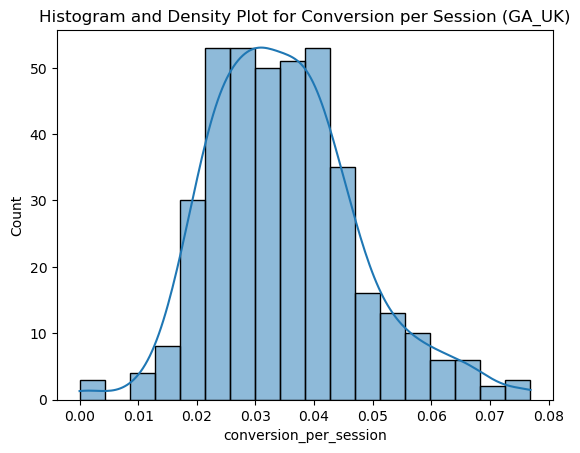

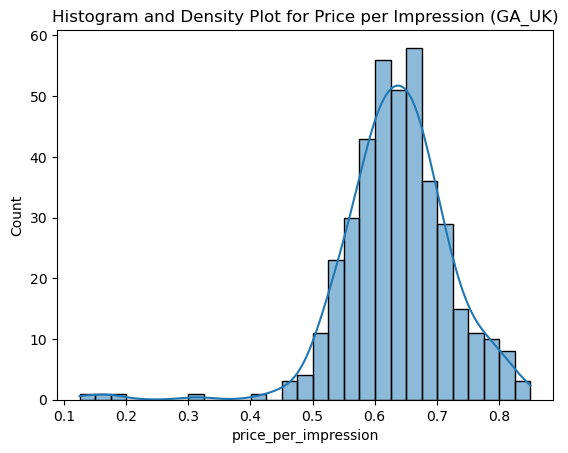

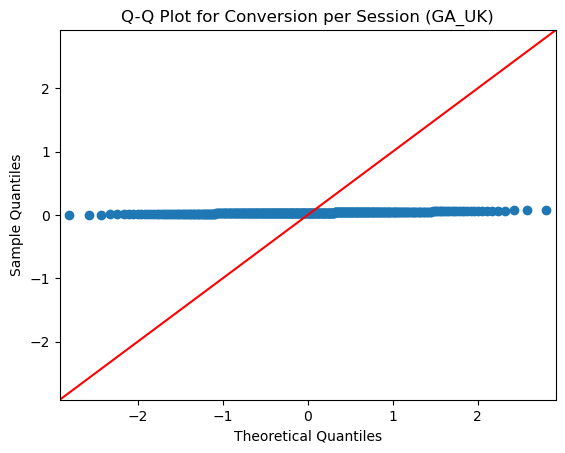

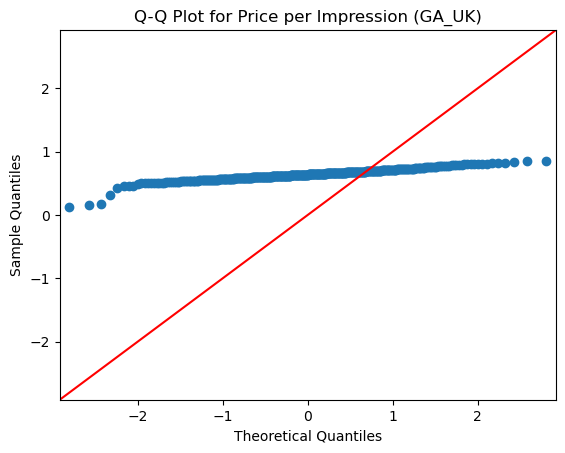

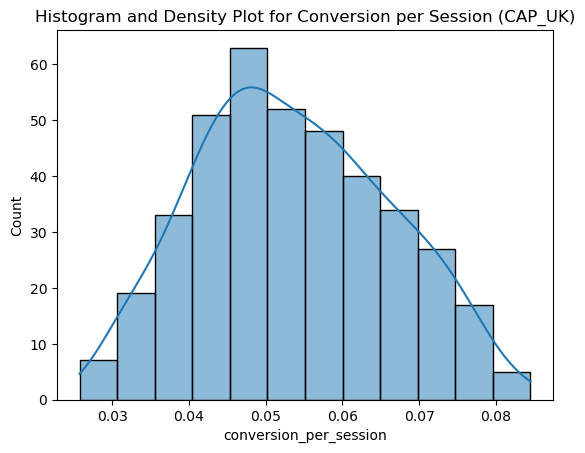

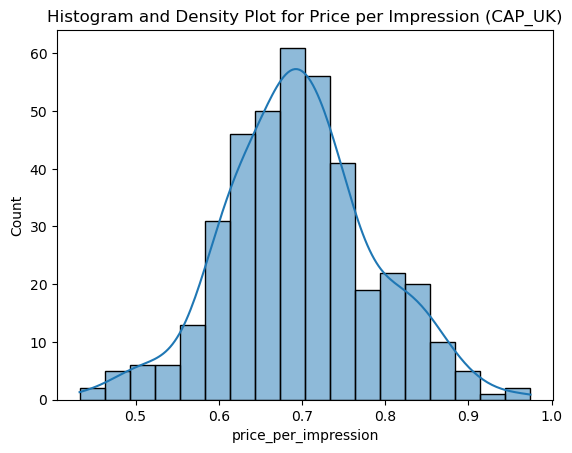

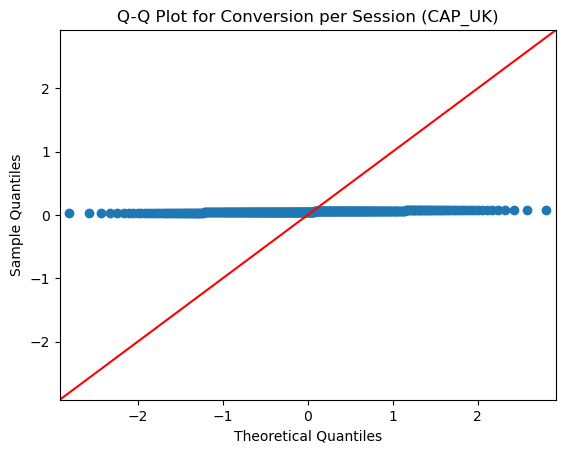

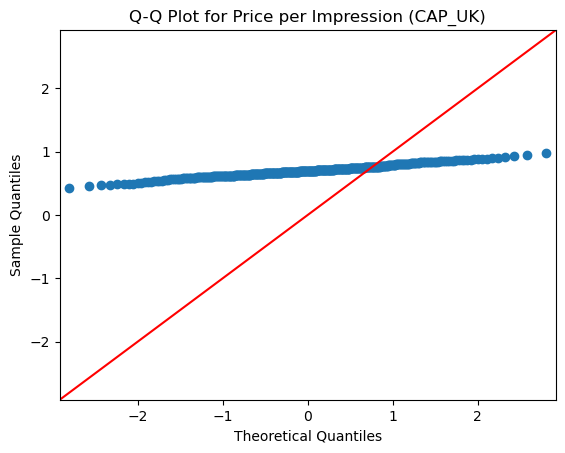

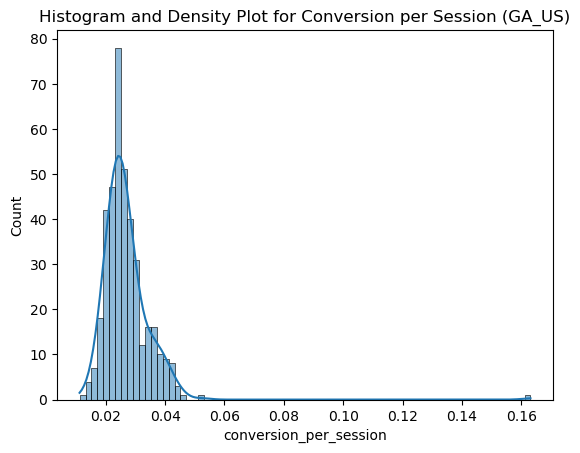

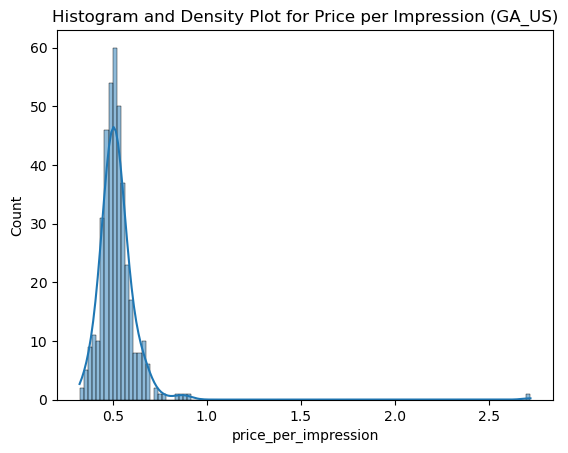

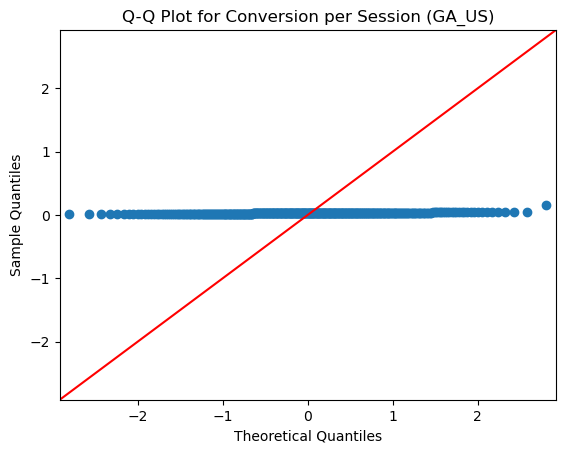

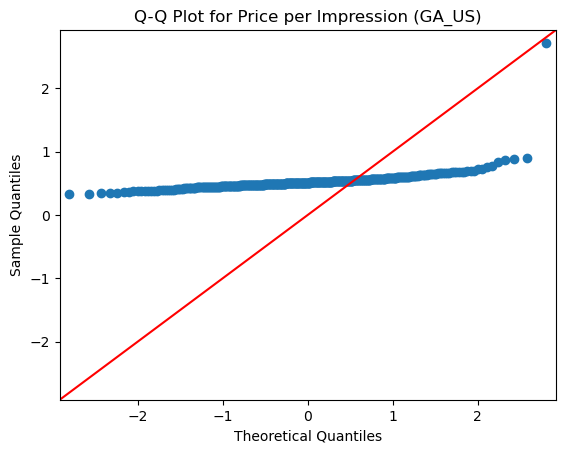

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm



for cohort, df in zip(cohorts, dataframes):
    # Histogram and density plot for 'conversion_per_session'
    sns.histplot(data=df, x='conversion_per_session', kde=True)
    plt.title(f'Histogram and Density Plot for Conversion per Session ({cohort})')
    plt.show()

    # Histogram and density plot for 'price_per_impression'
    sns.histplot(data=df, x='price_per_impression', kde=True)
    plt.title(f'Histogram and Density Plot for Price per Impression ({cohort})')
    plt.show()

    # Q-Q plot for 'conversion_per_session'
    sm.qqplot(df['conversion_per_session'], line='45')
    plt.title(f'Q-Q Plot for Conversion per Session ({cohort})')
    plt.show()

    # Q-Q plot for 'price_per_impression'
    sm.qqplot(df['price_per_impression'], line='45')
    plt.title(f'Q-Q Plot for Price per Impression ({cohort})')
    plt.show()



Observations of the ditributions:

- Histograms for conversion per session in cohorts CAP_US, GA_UK, CAP_UK, and GA_US show mostly symmetric distributions with a slight right skew.

- Histograms for price per impression in cohorts CAP_US, GA_UK, and CAP_UK show skewed distributions to the left, while in GA_US, it is skewed to the right.

- Q-Q plots for conversion per session in all cohorts indicate data points lying around zero.

- Q-Q plots for price per impression in all cohorts show data points slightly above zero.



In [17]:

# Create seprate dataframes for each cohort in log scale.


# We will study significant changes in the KPIs for each cohort between original data and log transformed data
df_cap_us_log = df_log[df_log['cohort'] == 'CAP_US']
df_ga_uk_log = df_log[df_log['cohort'] == 'GA_UK']
df_cap_uk_log = df_log[df_log['cohort'] == 'CAP_UK']
df_ga_us_log = df_log[df_log['cohort'] == 'GA_US']



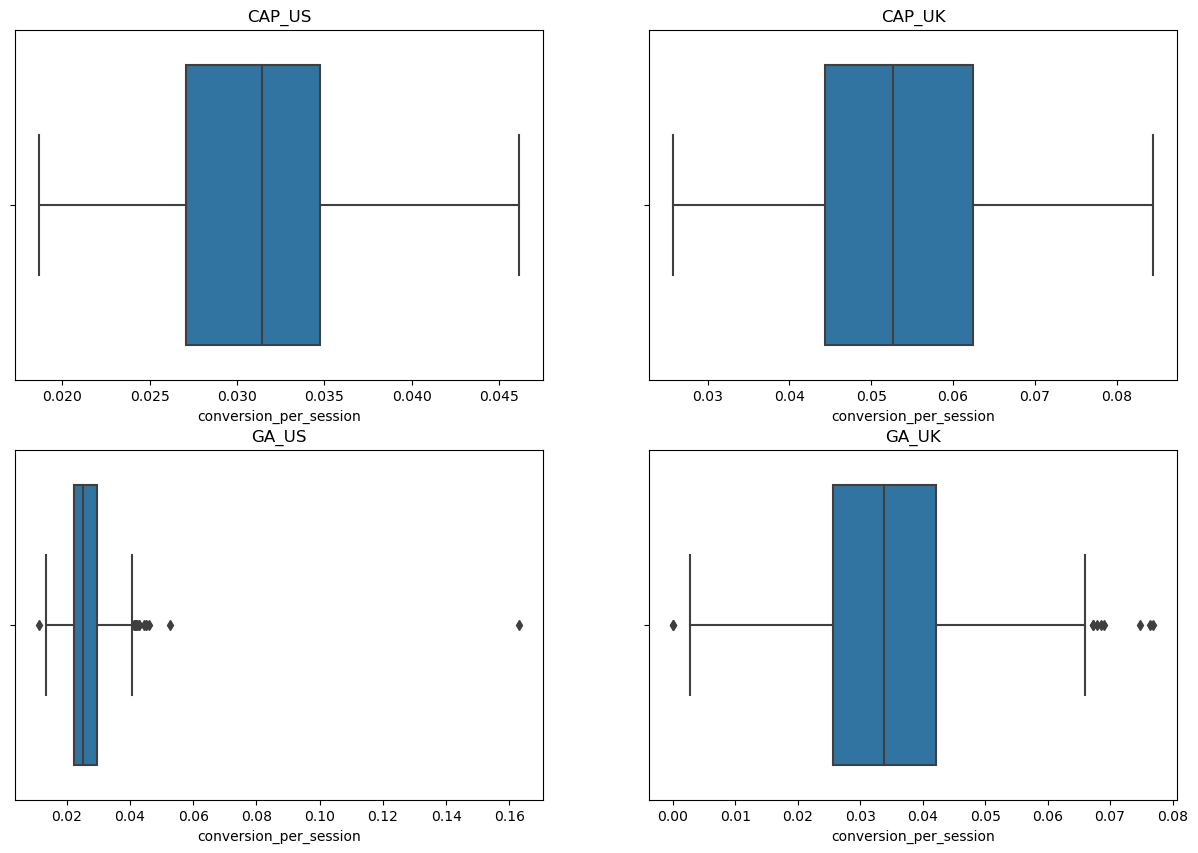

In [28]:
# Useful box plots to asses the presence of outliers

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='conversion_per_session' ,data=df_cap_us, ax=ax[0, 0])
sns.boxplot(x='conversion_per_session' ,data=df_cap_uk, ax=ax[0, 1])
sns.boxplot(x='conversion_per_session' ,data=df_ga_us, ax=ax[1, 0])
sns.boxplot(x='conversion_per_session' ,data=df_ga_uk, ax=ax[1, 1])
ax[0, 0].set_title('CAP_US')
ax[0, 1].set_title('CAP_UK')
ax[1, 0].set_title('GA_US')
ax[1, 1].set_title('GA_UK')
plt.show()

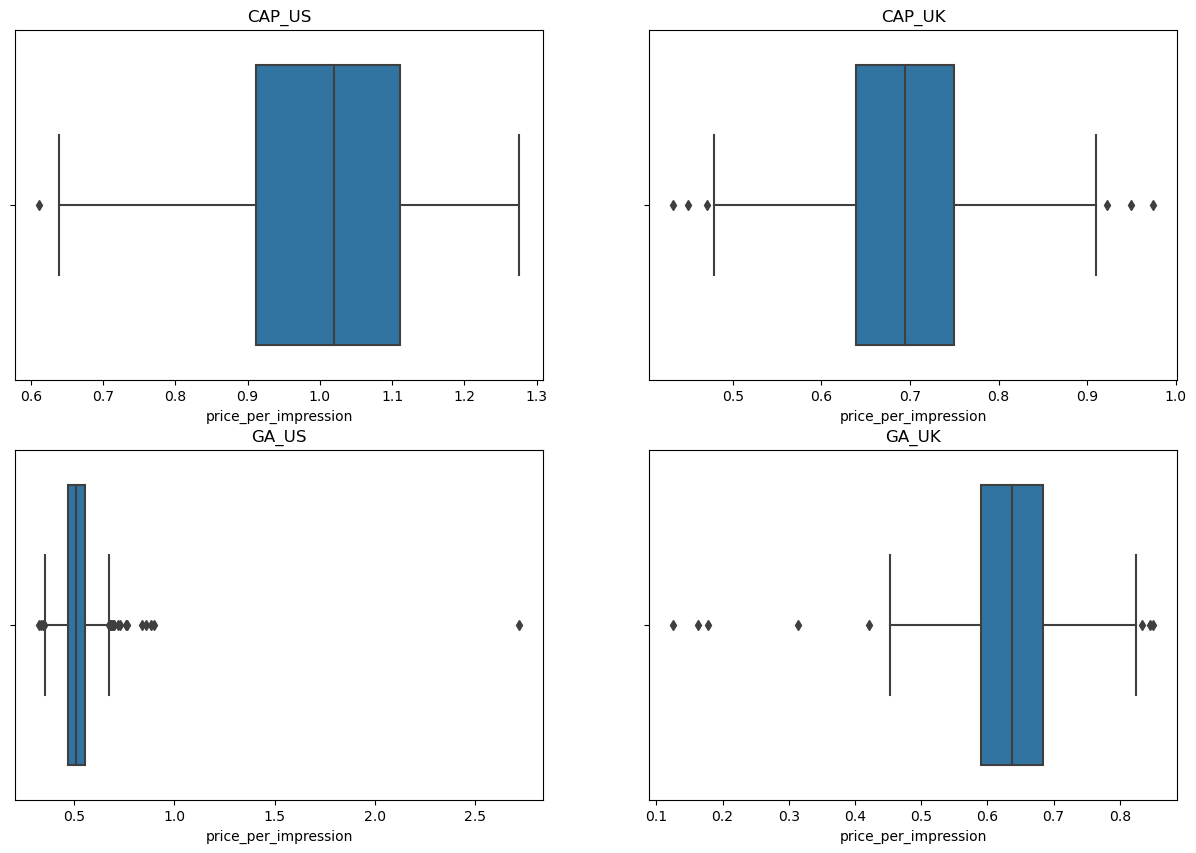

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='price_per_impression' ,data=df_cap_us, ax=ax[0, 0])
sns.boxplot(x='price_per_impression' ,data=df_cap_uk, ax=ax[0, 1])
sns.boxplot(x='price_per_impression' ,data=df_ga_us, ax=ax[1, 0])
sns.boxplot(x='price_per_impression' ,data=df_ga_uk, ax=ax[1, 1])
ax[0, 0].set_title('CAP_US')
ax[0, 1].set_title('CAP_UK')
ax[1, 0].set_title('GA_US')
ax[1, 1].set_title('GA_UK')
plt.show()

boxplot for log scale data


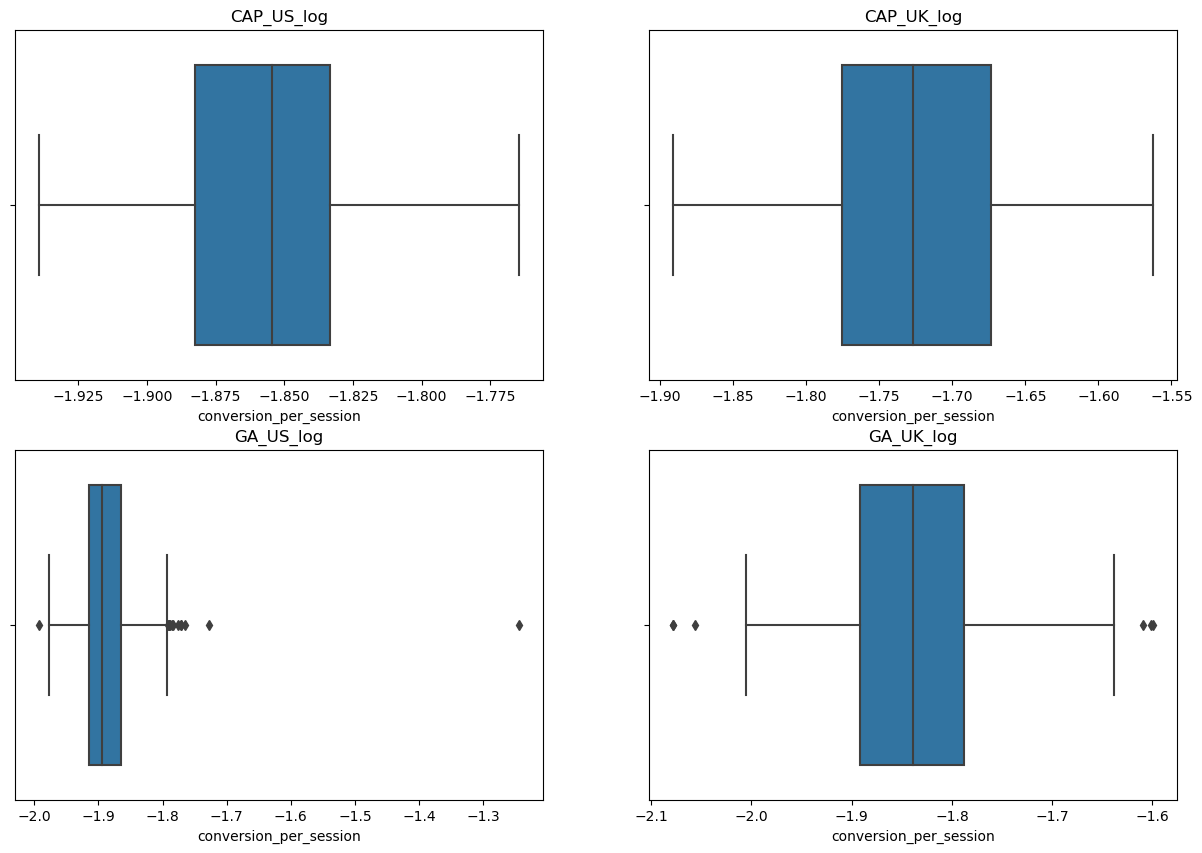

In [19]:
print('boxplot for log scale data')

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='conversion_per_session' ,data=df_cap_us_log, ax=ax[0, 0])
sns.boxplot(x='conversion_per_session' ,data=df_cap_uk_log, ax=ax[0, 1])
sns.boxplot(x='conversion_per_session' ,data=df_ga_us_log, ax=ax[1, 0])
sns.boxplot(x='conversion_per_session' ,data=df_ga_uk_log, ax=ax[1, 1])
ax[0, 0].set_title('CAP_US_log')
ax[0, 1].set_title('CAP_UK_log')
ax[1, 0].set_title('GA_US_log')
ax[1, 1].set_title('GA_UK_log')
plt.show()

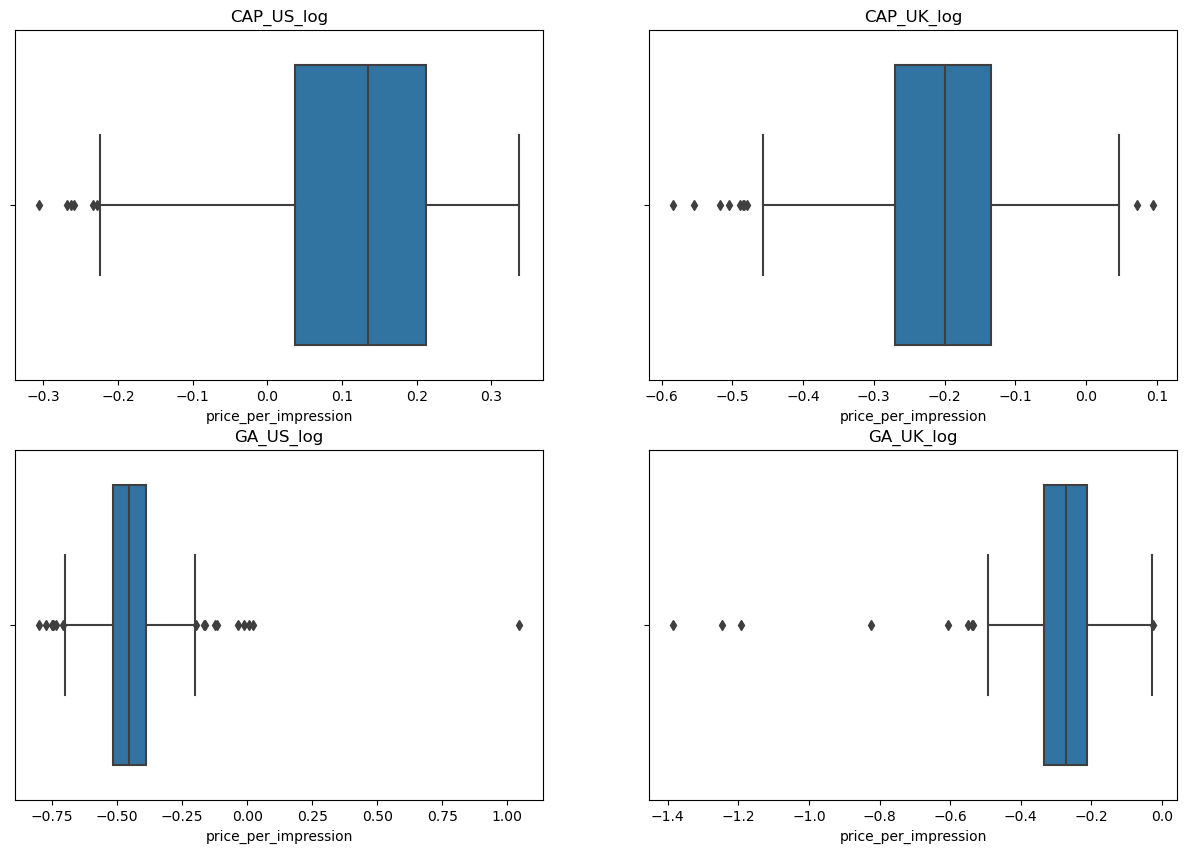

In [20]:

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='price_per_impression' ,data=df_cap_us_log, ax=ax[0, 0])
sns.boxplot(x='price_per_impression' ,data=df_cap_uk_log, ax=ax[0, 1])
sns.boxplot(x='price_per_impression' ,data=df_ga_us_log, ax=ax[1, 0])
sns.boxplot(x='price_per_impression' ,data=df_ga_uk_log, ax=ax[1, 1])
ax[0, 0].set_title('CAP_US_log')
ax[0, 1].set_title('CAP_UK_log')
ax[1, 0].set_title('GA_US_log')
ax[1, 1].set_title('GA_UK_log')
plt.show()

Log-transformed Data:


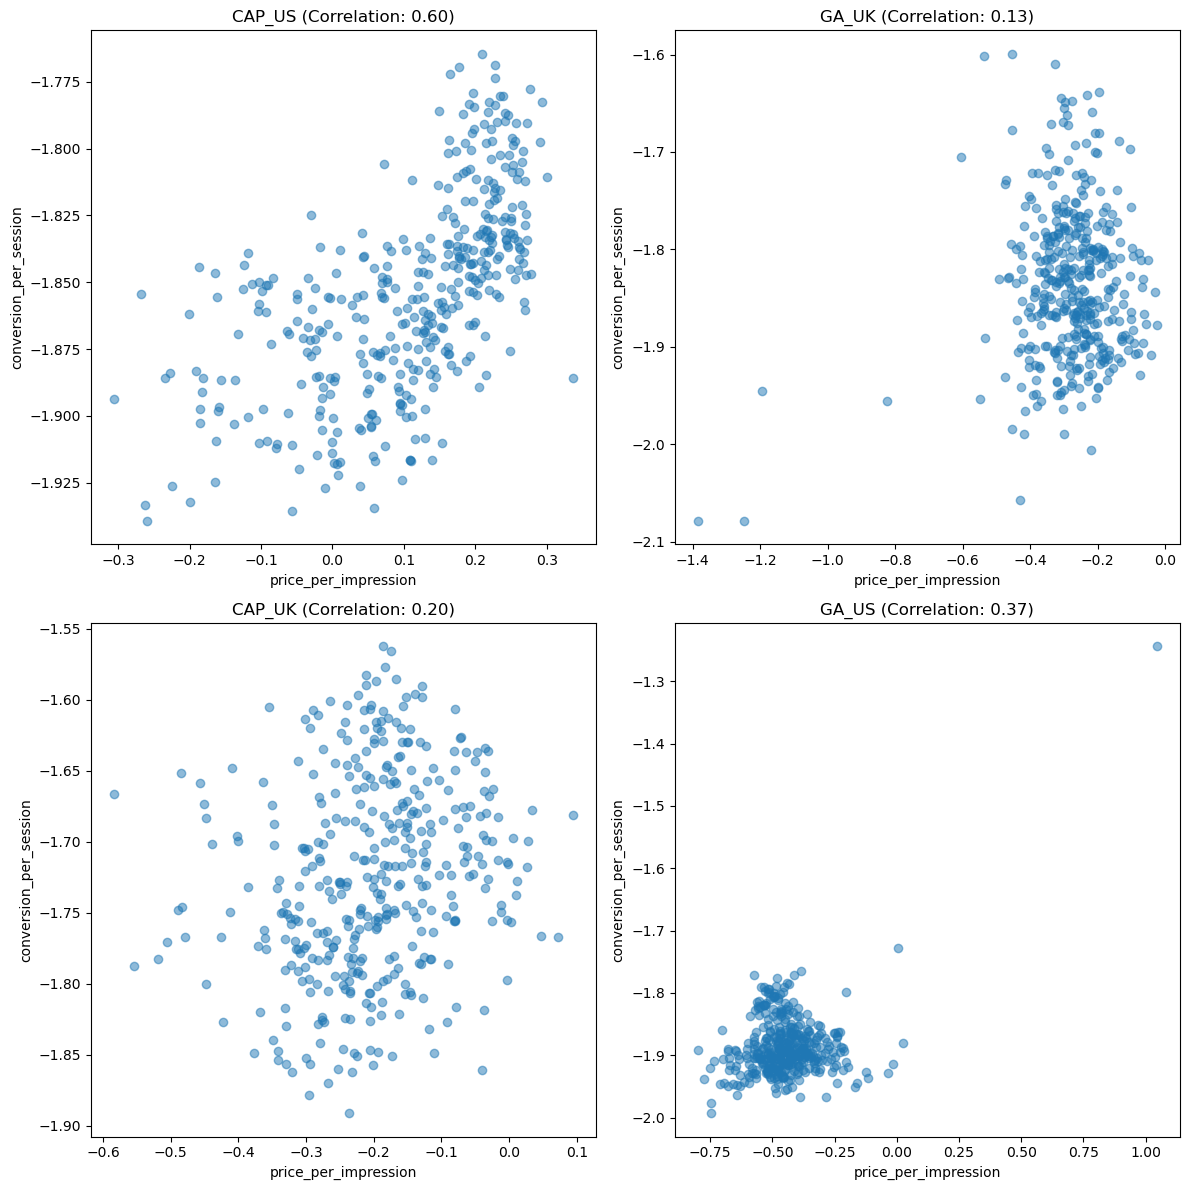

In [25]:

# Log-transformed Data relationships
dataframes_log = [df_cap_us_log, df_ga_uk_log, df_cap_uk_log, df_ga_us_log]
print("Log-transformed Data:")
plot_relationships(dataframes_log, cohorts)

In [26]:
# Function to display correlation matrix with background gradient style
def display_correlations(dataframes, cohorts):
    for cohort, df in zip(cohorts, dataframes):
        print(f"Correlation matrix for {cohort}:")
        display(df.corr().style.background_gradient(cmap='coolwarm'))
        print("\n")

# Original Data
print("Original Data:")
display_correlations(dataframes, cohorts)




Original Data:
Correlation matrix for CAP_US:


,total_spend,impressions,sessions,conversions,conversion_per_session,price_per_impression
total_spend,1.000000,0.861574,0.861068,0.873671,0.497146,0.631954
impressions,0.861574,1.000000,0.999623,0.809369,0.239438,0.162610
sessions,0.861068,0.999623,1.000000,0.809066,0.238583,0.162167
conversions,0.873671,0.809369,0.809066,1.000000,0.757028,0.476422
conversion_per_session,0.497146,0.239438,0.238583,0.757028,1.000000,0.618502
price_per_impression,0.631954,0.162610,0.162167,0.476422,0.618502,1.000000




Correlation matrix for GA_UK:


,total_spend,impressions,sessions,conversions,conversion_per_session,price_per_impression
total_spend,1.000000,0.943564,0.943450,0.624154,0.047673,0.572535
impressions,0.943564,1.000000,0.999826,0.677955,0.069038,0.320539
sessions,0.943450,0.999826,1.000000,0.678735,0.070118,0.320764
conversions,0.624154,0.677955,0.678735,1.000000,0.736991,0.190901
conversion_per_session,0.047673,0.069038,0.070118,0.736991,1.000000,0.057122
price_per_impression,0.572535,0.320539,0.320764,0.190901,0.057122,1.000000




Correlation matrix for CAP_UK:


,total_spend,impressions,sessions,conversions,conversion_per_session,price_per_impression
total_spend,1.000000,0.939122,0.939187,0.792306,0.135928,0.463362
impressions,0.939122,1.000000,0.999837,0.799054,0.079953,0.145248
sessions,0.939187,0.999837,1.000000,0.798829,0.079372,0.146018
conversions,0.792306,0.799054,0.798829,1.000000,0.646982,0.230027
conversion_per_session,0.135928,0.079953,0.079372,0.646982,1.000000,0.190619
price_per_impression,0.463362,0.145248,0.146018,0.230027,0.190619,1.000000




Correlation matrix for GA_US:


,total_spend,impressions,sessions,conversions,conversion_per_session,price_per_impression
total_spend,1.000000,0.894294,0.893907,0.714523,0.155646,0.388358
impressions,0.894294,1.000000,0.999754,0.798208,0.067428,0.035191
sessions,0.893907,0.999754,1.000000,0.798736,0.067622,0.034872
conversions,0.714523,0.798208,0.798736,1.000000,0.548274,0.140870
conversion_per_session,0.155646,0.067428,0.067622,0.548274,1.000000,0.609477
price_per_impression,0.388358,0.035191,0.034872,0.140870,0.609477,1.000000


Observations:




- When it comes to outliers in key variables. Cohorts of CAP_US and CAP_UK do not present any outliers in conversion per session, both for original features and log scale features. However, GA_US and GA_UK do present outliers in conversion per session, both for original features and log scale featues. Outliers do not represent a signifcant presence.

- Price per impression is the variable that presents the most outliers. Outliers are present in all cohorts, both for original features and log scale featues.

- The visual relationship between price per impression and conversion per session on the scatter plot is not linear for all cohorts, even for log scale cohorts still not linear. Pearson correlation for all cohorts is weak. There is a slight increase for log scale cohorts with the highest correlation being 0.60 for CAP_US 

- After this analysis. We have observed that the nature of the data for each cohort is different. 

- Logarithm transformation seems potential starting point to address the non-linearity of the data. As far as outliers there is clear evidence that a tratment for outliers for each cohort should be donde ideally. This could be done by ususing a robut model nont sensitive to outliers or treat outliers seperartly for each cohort.

- Polynomial transformation also seems a good starting point to enhace model performance, although further analysis is needed to determine the best tecnique to apply.

Next steps:

- Check for multicollinearity between variables and data leakage

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Function to display VIF for each dataframe
def display_vif(dataframes: List[pd.DataFrame], cohorts: List[str]):
    vif_cols = ['total_spend', 'impressions', 'sessions', 'conversions',
       'price_per_impression', 'conversion_per_session']
    for cohort, df in zip(cohorts, dataframes):
        print(f"VIF for {cohort}:")
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(df[vif_cols].values, i) for i in range(len(vif_cols))]
        vif["features"] = vif_cols
        display(vif.sort_values(by='VIF Factor', ascending=False).style.background_gradient(cmap='coolwarm'))
        print("\n")

In [28]:
display_vif(dataframes, cohorts)

VIF for CAP_US:


,VIF Factor,features
1,30898.620873,impressions
2,30852.978437,sessions
3,1361.587533,conversions
5,1289.291426,conversion_per_session
0,1221.211679,total_spend
4,1168.971737,price_per_impression




VIF for GA_UK:


,VIF Factor,features
2,34184.063797,sessions
1,34158.540124,impressions
0,158.439431,total_spend
3,107.276351,conversions
4,89.770147,price_per_impression
5,89.272255,conversion_per_session




VIF for CAP_UK:


,VIF Factor,features
1,32714.172967,impressions
2,32679.692706,sessions
0,408.176567,total_spend
3,384.977879,conversions
5,343.814726,conversion_per_session
4,283.429089,price_per_impression




VIF for GA_US:


,VIF Factor,features
2,30463.185155,sessions
1,30454.300349,impressions
3,325.258335,conversions
0,303.032928,total_spend
4,297.087909,price_per_impression
5,283.840473,conversion_per_session


Observations:

- Since there is high multicollinearity between sessions and impressions, using these variables will only decrease performance.

- For conversions and total_spend, multicollinearity is somewhat less significant. However, to avoid data leakage, we will drop these variables and focus on modeling the relationship between our two KPIs.

- Therefore we will maintain the following variables: price_per_impression, conversion_per_session, checking for relationships


Next steps:
- As a final approach
- We will use robust models to potentially address outliers and non-linearity
- Logarithm transformation and Polynomial transformation will be applied to the data
- conversion_per_session will be the target variable and price per impression will be serve as optimization function
- As per the forecast model approach Prophet is the selected model, we will add monthly seasonality a model

In [29]:
# Define input for the approach to optimize price per impression taht maximizes conversion per session

cohort_dataframes = {
    'CAP_US': df_cap_us,
    'GA_UK': df_ga_uk,
    'CAP_UK': df_cap_uk,
    'GA_US': df_ga_us,
}

In [30]:
# Run the campaign manager

from src.campaign_manager import CampaignManager
campaign_manager = CampaignManager(cohort_dataframes)
campaign_manager.run()

[I 2023-03-22 15:20:13,223] A new study created in memory with name: no-name-961d7ecd-95ac-4f6e-b625-9993aae2ceac
[I 2023-03-22 15:20:13,237] Trial 0 finished with value: -0.19243746033717402 and parameters: {'price_per_impression': 3.4885212599064013}. Best is trial 0 with value: -0.19243746033717402.
[I 2023-03-22 15:20:13,241] Trial 1 finished with value: -0.0378521547438499 and parameters: {'price_per_impression': 1.1781844481277604}. Best is trial 0 with value: -0.19243746033717402.
[I 2023-03-22 15:20:13,253] Trial 2 finished with value: -0.20444686145237256 and parameters: {'price_per_impression': 3.652186522105854}. Best is trial 2 with value: -0.20444686145237256.
[I 2023-03-22 15:20:13,255] Trial 3 finished with value: -0.05827763296677854 and parameters: {'price_per_impression': 1.567122926772227}. Best is trial 2 with value: -0.20444686145237256.
[I 2023-03-22 15:20:13,257] Trial 4 finished with value: -0.18588320340555564 and parameters: {'price_per_impression': 3.39928199

Processing CAP_US cohort...


[I 2023-03-22 15:20:13,452] Trial 16 finished with value: -0.6159834007578193 and parameters: {'price_per_impression': 9.989940028474692}. Best is trial 16 with value: -0.6159834007578193.
[I 2023-03-22 15:20:13,470] Trial 17 finished with value: -0.3836437644352565 and parameters: {'price_per_impression': 6.195408946304707}. Best is trial 16 with value: -0.6159834007578193.
[I 2023-03-22 15:20:13,494] Trial 18 finished with value: -0.04891135287990683 and parameters: {'price_per_impression': 0.07156630719109636}. Best is trial 16 with value: -0.6159834007578193.
[I 2023-03-22 15:20:13,508] Trial 19 finished with value: -0.5389797125890526 and parameters: {'price_per_impression': 8.657293776183336}. Best is trial 16 with value: -0.6159834007578193.
[I 2023-03-22 15:20:13,515] Trial 20 finished with value: -0.41630177907334953 and parameters: {'price_per_impression': 6.689872646234706}. Best is trial 16 with value: -0.6159834007578193.
[I 2023-03-22 15:20:13,530] Trial 21 finished with 

Optimal Price per Impression: 9.998099466526638
Mean Squared Error (Test Set): 3.6152114338643475e-05


Processing GA_UK cohort...


[I 2023-03-22 15:20:14,113] Trial 25 finished with value: -0.03315324642867074 and parameters: {'price_per_impression': 0.7912147202000389}. Best is trial 23 with value: -0.03624001782555599.
[I 2023-03-22 15:20:14,119] Trial 26 finished with value: -0.03098937375028745 and parameters: {'price_per_impression': 0.8489192854042626}. Best is trial 23 with value: -0.03624001782555599.
[I 2023-03-22 15:20:14,127] Trial 27 finished with value: 0.04610393138171039 and parameters: {'price_per_impression': 1.8014540680187614}. Best is trial 23 with value: -0.03624001782555599.
[I 2023-03-22 15:20:14,139] Trial 28 finished with value: 0.1951337507375869 and parameters: {'price_per_impression': 3.090350643894088}. Best is trial 23 with value: -0.03624001782555599.
[I 2023-03-22 15:20:14,176] Trial 29 finished with value: 0.2884828449644059 and parameters: {'price_per_impression': 3.8646454204917693}. Best is trial 23 with value: -0.03624001782555599.
[I 2023-03-22 15:20:14,242] Trial 30 finished 

Optimal Price per Impression: 0.6095251715142019
Mean Squared Error (Test Set): 0.0001370894421014469


Processing CAP_UK cohort...


[I 2023-03-22 15:20:14,709] Trial 26 finished with value: -0.055457361272795554 and parameters: {'price_per_impression': 0.7333215899404459}. Best is trial 24 with value: -0.05637131950530377.
[I 2023-03-22 15:20:14,718] Trial 27 finished with value: 0.059383652961078344 and parameters: {'price_per_impression': 2.550662223585409}. Best is trial 24 with value: -0.05637131950530377.
[I 2023-03-22 15:20:14,723] Trial 28 finished with value: -0.05618805480730788 and parameters: {'price_per_impression': 0.7683093735585703}. Best is trial 24 with value: -0.05637131950530377.
[I 2023-03-22 15:20:14,729] Trial 29 finished with value: -0.02171304391466449 and parameters: {'price_per_impression': 0.31129659119486}. Best is trial 24 with value: -0.05637131950530377.
[I 2023-03-22 15:20:14,736] Trial 30 finished with value: -0.05540134066436014 and parameters: {'price_per_impression': 0.7310423013308942}. Best is trial 24 with value: -0.05637131950530377.
[I 2023-03-22 15:20:14,743] Trial 31 finis

Optimal Price per Impression: 0.8544884952400951
Mean Squared Error (Test Set): 0.00016139565309726298


Processing GA_US cohort...


[I 2023-03-22 15:20:15,231] Trial 19 finished with value: 0.01778183141382712 and parameters: {'price_per_impression': 1.1823378031597587}. Best is trial 12 with value: -0.018008690019070992.
[I 2023-03-22 15:20:15,240] Trial 20 finished with value: 0.3365035117086256 and parameters: {'price_per_impression': 3.305601284032091}. Best is trial 12 with value: -0.018008690019070992.
[I 2023-03-22 15:20:15,250] Trial 21 finished with value: -0.0071262863214660195 and parameters: {'price_per_impression': 0.9308493664309688}. Best is trial 12 with value: -0.018008690019070992.
[I 2023-03-22 15:20:15,259] Trial 22 finished with value: 0.11853543778525676 and parameters: {'price_per_impression': 1.93085775139458}. Best is trial 12 with value: -0.018008690019070992.
[I 2023-03-22 15:20:15,284] Trial 23 finished with value: -0.026133666353933483 and parameters: {'price_per_impression': 0.5960836321169046}. Best is trial 23 with value: -0.026133666353933483.
[I 2023-03-22 15:20:15,289] Trial 24 fi

Optimal Price per Impression: 0.5267114765038974
Mean Squared Error (Test Set): 0.005561628630341672




15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


Total budget $75137106.46 for the next 14 days for cohort CAP_US
Adjusted total budget for the next 14 days: $753745431.37
Total budget $1244906.09 for the next 14 days for cohort GA_UK
Adjusted total budget for the next 14 days: $1192339.65


15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


Total budget $13734499.20 for the next 14 days for cohort CAP_UK
Adjusted total budget for the next 14 days: $16851393.62
Total budget $20737293.57 for the next 14 days for cohort GA_US
Adjusted total budget for the next 14 days: $20865053.04


**Thanks!**